# Introduction to Bayesian Inference via Grid Approximation

by Henry Bechtel 

I have found many introductions to Bayesian analysis that tend to be either too simplistic or too complex. I think grid methods are a good middle-ground and offer great insight into how Bayesian inference works. 

Here we will go beyond simple, toy examples, pushing grid approximation to its limits so we can see why MCMC methods are required for more complex problems.

I'm going to be using a lot of for-loops in my grids and since Julia is great with loops, I'm using it to make things a little more snappy.

Special thanks to excellent, inspirational work by Allen Downey, Richard McElreath, and Brandon Rohrer.

In [117]:
using Plots

Here we'll define the probability density function for the normal distribution. We'll use this later to calculate the likelihood for Bayes rule.

In [118]:
function normal_pdf(x, mu=0, sig=1)
    exp(-(x-mu)^2/(2*sig^2))/sqrt(2*pi*sig^2)
end

normal_pdf (generic function with 3 methods)

# Simple Linear Regression 
Here we will simulate some data and try to recover our parameters.

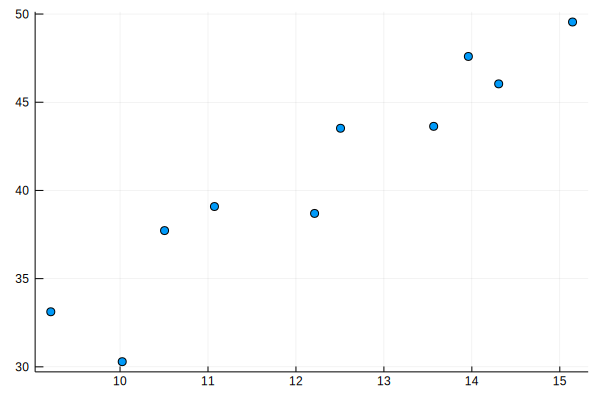

In [123]:
b0_true = 4
b1_true = 3
s_true = 2
num_observations = 10

x = 11 .+ randn(num_observations)*2
y = b0_true .+ b1_true*x .+ randn(length(x))*s_true;

scatter(x,y, legend=false)

In [76]:
x = [10.506, 13.9605, 10.0248, 9.21246, 13.5658, 12.2118, 12.5068, 15.1448, 11.0734, 14.3051] 
y = [37.7241, 47.5949, 30.2924, 33.1214, 43.6333, 38.6968, 43.5251, 49.5484, 39.088, 46.0416];

Setting up our "grid" for three parameters we are trying to infer

In [100]:
hyp_b0 = LinRange(3, 6, 101)
hyp_b1 = LinRange(2.5, 3.5, 101)
hyp_s = LinRange(0.01, 4, 101);

In [101]:
prior = ones(length(hyp_b0),length(hyp_b1),length(hyp_s))
unnormalized_posterior = zeros(size(prior));

In [102]:
length(hyp_b0)*length(hyp_b1)*length(hyp_s)*length(x)

10303010

In [103]:
marginal_likelihood = 0
for i in 1:length(hyp_b0)
    b0 = hyp_b0[i]
    for j in 1:length(hyp_b1)
        b1 = hyp_b1[j]
        for k in 1:length(hyp_s)
            s = hyp_s[k]
            unnormalized_likelihood = 1
            for d in 1:length(y)
                mean = b0 + b1*x[d]
                unnormalized_likelihood *= normal_pdf(y[d], mean, s)
            end
            unnormalized_posterior[i,j,k] = unnormalized_likelihood*prior[i,j,k]
            marginal_likelihood += unnormalized_likelihood*prior[i,j,k]
        end
    end
end

posterior = unnormalized_posterior/marginal_likelihood;

In [104]:
val, idx = findmax(posterior[:,:,:])
idx

CartesianIndex(56, 47, 49)

In [105]:
println("Max Posterior Estimate for b0 is: ", hyp_b0[idx[1]])
println("Max Posterior Estimate for b1 is: ", hyp_b1[idx[2]])
println("Max Posterior Estimate for s is: ", hyp_s[idx[3]])

Max Posterior Estimate for b0 is: 4.65
Max Posterior Estimate for b1 is: 2.96
Max Posterior Estimate for s is: 1.9252


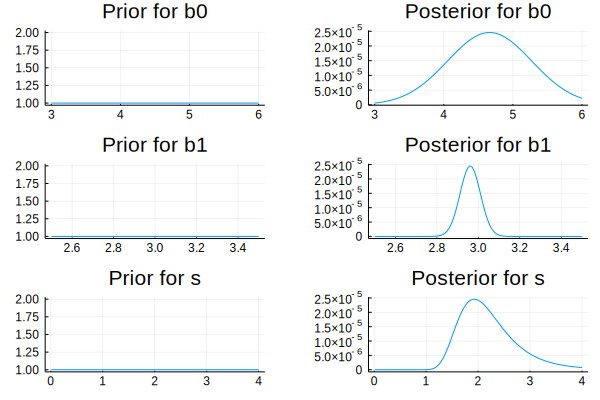

In [106]:
p1 = plot(hyp_b0, prior[:,idx[2],idx[3]], title="Prior for b0")
p2 = plot(hyp_b1, prior[idx[1],:,idx[3]], title="Prior for b1")
p3 = plot(hyp_s, prior[idx[1],idx[2],:], title="Prior for s")
p4 = plot(hyp_b0, posterior[:,idx[2],idx[3]], title="Posterior for b0")
p5 = plot(hyp_b1, posterior[idx[1],:,idx[3]], title="Posterior for b1")
p6 = plot(hyp_s, posterior[idx[1],idx[2],:], title="Posterior for s")
plot(p1,p4,p2,p5,p3,p6, layout=(3,2), legend=false)

# Multiple Linear Regression
Here I'm using exact data taken from an example from a pymc3 tutorial. We will try to recreate the same pymc3 results that use MCMC methods.

In [119]:
X1 = [-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ,
        0.73736858,  1.49073203, -0.93583387,  1.17582904, -1.25388067,
       -0.6377515 ,  0.9071052 , -1.4286807 , -0.14006872, -0.8617549 ,
       -0.25561937, -2.79858911, -1.7715331 , -0.69987723,  0.92746243,
       -0.17363568,  0.00284592,  0.68822271, -0.87953634,  0.28362732,
       -0.80536652, -1.72766949, -0.39089979,  0.57380586,  0.33858905,
       -0.01183049,  2.39236527,  0.41291216,  0.97873601,  2.23814334,
       -1.29408532, -1.03878821,  1.74371223, -0.79806274,  0.02968323,
        1.06931597,  0.89070639,  1.75488618,  1.49564414,  1.06939267,
       -0.77270871,  0.79486267,  0.31427199, -1.32626546,  1.41729905,
        0.80723653,  0.04549008, -0.23309206, -1.19830114,  0.19952407,
        0.46843912, -0.83115498,  1.16220405, -1.09720305, -2.12310035,
        1.03972709, -0.40336604, -0.12602959, -0.83751672, -1.60596276,
        1.25523737, -0.68886898,  1.66095249,  0.80730819, -0.31475815,
       -1.0859024 , -0.73246199, -1.21252313,  2.08711336,  0.16444123,
        1.15020554, -1.26735205,  0.18103513,  1.17786194, -0.33501076,
        1.03111446, -1.08456791, -1.36347154,  0.37940061, -0.37917643];

In [120]:
X2 = [ 0.12841094, -0.39557759,  0.14245293,  0.51966079, -0.0049252 ,
        0.00682843,  0.0359099 , -0.37239514,  0.08522933, -0.32108195,
       -0.08553592,  0.24857391, -0.14704339,  0.1002498 ,  0.20254781,
        0.05574817, -0.27418969, -0.06649506,  0.39188227, -0.40500915,
       -0.0551572 , -0.11042161,  0.02414947,  0.14964312,  0.32173819,
       -0.05404648,  0.16246827,  0.09994803,  0.09486946, -0.11278479,
       -0.19946429, -0.22000862, -0.15128744,  0.06433732,  0.15218988,
        0.06469377, -0.10979102,  0.36119402,  0.30377312, -0.07080002,
       -0.16468628,  0.02604299,  0.25345973,  0.066553  ,  0.11130974,
       -0.04241602,  0.09125418,  0.30890889, -0.04793376,  0.02866155,
        0.0507633 ,  0.05674507, -0.28237778, -0.37537373, -0.20393101,
        0.03358846,  0.11077123, -0.10613491,  0.2754515 , -0.02863519,
        0.0040632 , -0.03879277,  0.02680536,  0.14089481,  0.13313069,
       -0.17968459,  0.30473276, -0.21900529,  0.0158454 , -0.05487931,
       -0.20979834, -0.01502412, -0.14816275,  0.01458145,  0.08061719,
        0.29438587,  0.06147684, -0.12224507, -0.07832396,  0.02799562,
        0.01869217,  0.29191785,  0.27907059, -0.07178719, -0.10972843,
       -0.51141092, -0.10978408, -0.19561154, -0.07096489,  0.07831685,
        0.03543847, -0.0059936 ,  0.03991642, -0.02522355,  0.03940379,
       -0.646211  , -0.0538587 , -0.02217014, -0.06825234, -0.04358925];

In [121]:
Y = [ 9.38706859e-01,  4.10296149e-01,  3.83981292e+00,  1.48115418e+00,
        4.02779506e-01,  2.46184530e+00, -1.42342679e+00, -1.27520755e+00,
        2.38380704e+00, -3.90761758e-01,  6.86815665e-01,  2.10641559e+00,
        1.84890360e+00, -8.04359754e-01,  3.93284941e-01,  2.31721220e+00,
        3.41651416e+00,  3.39016804e+00,  2.22246532e+00,  3.77308673e-01,
        3.43806883e-01,  1.66274112e+00, -1.20663529e-01,  2.18829692e+00,
        1.50706675e+00, -1.19159361e+00,  1.44784359e+00, -1.55349860e+00,
       -1.40248284e-01, -1.96609652e-02, -1.35472064e+00, -1.59474188e+00,
       -1.39656749e+00,  5.29754386e-01,  2.63051387e+00,  5.53932221e-01,
        1.76084808e+00,  2.39686504e+00,  1.47396672e+00,  9.07514885e-01,
        7.37921664e-02, -3.82899347e-01,  1.49271947e+00,  7.65880501e-01,
        2.05273917e+00,  5.63172455e-01,  4.25098874e+00,  3.26909416e-02,
        3.93785393e-01,  3.67324277e+00,  1.69575050e+00,  9.38133214e-01,
        1.35531685e+00, -2.42854948e+00,  1.26254192e+00,  2.07270390e+00,
        2.75833869e+00,  2.60484762e+00,  3.21391580e+00,  4.95643013e+00,
        2.31319324e-01,  1.53863552e+00,  1.25983672e+00, -5.57565140e-01,
        3.74025866e+00,  1.00427073e+00,  2.44326467e+00,  5.03997740e-01,
        1.06029822e+00,  1.48250538e+00, -2.69441500e-01, -1.19520306e+00,
        3.20016631e+00, -6.69460228e-01, -2.24215995e+00,  2.10607318e+00,
        2.01495136e+00, -8.51855254e-01, -8.99821832e-01, -1.20278122e+00,
        1.05077792e+00, -1.43401688e-01,  1.84052098e+00,  1.16665281e+00,
        5.60119574e-02, -2.04696786e+00, -1.66062003e+00,  5.51783963e-01,
        1.58062230e+00,  1.63826706e+00,  1.16403511e+00,  3.85980814e-01,
        2.23665854e+00,  1.23718947e+00, -1.16021703e+00,  1.11137427e+00,
        1.65658589e+00, -3.20236525e-03,  1.36931418e+00,  1.33161104e+00];

Now we have four parameters that we will need grids for.

In [122]:
hyp_alpha = LinRange(0.5,1.3,30)
hyp_beta1 = LinRange(0.6,1.25,30)
hyp_beta2 = LinRange(0,5,50)
hyp_sigma = LinRange(0.8,1.3,30);  

In [123]:
prior = ones(length(hyp_alpha),length(hyp_beta1),length(hyp_beta2),length(hyp_sigma))
unnormalized_posterior = zeros(size(prior));

In [124]:
length(hyp_alpha)*length(hyp_beta1)*length(hyp_beta2)*length(hyp_sigma)*length(Y)

162000000

In [125]:
marginal_likelihood = 0
for i in 1:length(hyp_alpha)
    alpha = hyp_alpha[i]
    for j in 1:length(hyp_beta1)
        beta1 = hyp_beta1[j]
        for k in 1:length(hyp_beta2)
            beta2 = hyp_beta2[k]
            for l in 1:length(hyp_sigma)
                sigma = hyp_sigma[l]
                likelihood = 1
                for d in 1:length(Y)
                    mean = alpha + beta1*X1[d] + beta2*X2[d]
                    likelihood *= normal_pdf(Y[d], mean, sigma)
                end
                unnormalized_posterior[i,j,k,l] = likelihood*prior[i,j,k,l]
                marginal_likelihood += likelihood*prior[i,j,k,l]
            end
        end
    end
end
    
posterior = unnormalized_posterior/marginal_likelihood;

In [126]:
val, idx = findmax(posterior[:,:,:,:])
idx

CartesianIndex(16, 17, 32, 11)

In [127]:
println("Max Posterior Estimate for alpha is: ", hyp_alpha[idx[1]])
println("Max Posterior Estimate for beta1 is: ", hyp_beta1[idx[2]])
println("Max Posterior Estimate for beta2 is: ", hyp_beta2[idx[3]])
println("Max Posterior Estimate for sigma is: ", hyp_sigma[idx[4]])

Max Posterior Estimate for alpha is: 0.913793103448276
Max Posterior Estimate for beta1 is: 0.9586206896551724
Max Posterior Estimate for beta2 is: 2.6271186440677967
Max Posterior Estimate for sigma is: 0.9724137931034484


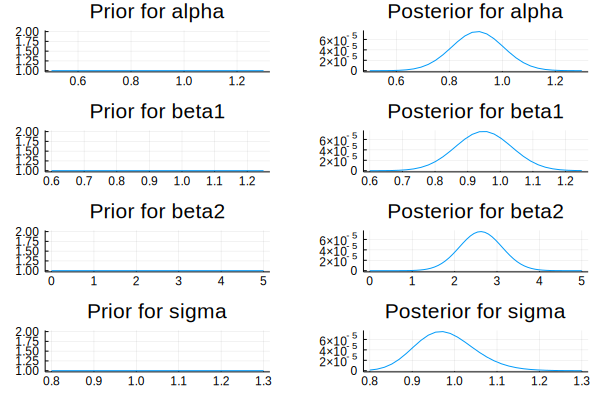

In [128]:
p1 = plot(hyp_alpha, prior[:,idx[2],idx[3],idx[4]], title="Prior for alpha")
p2 = plot(hyp_beta1, prior[idx[1],:,idx[3],idx[4]], title="Prior for beta1")
p3 = plot(hyp_beta2, prior[idx[1],idx[2],:,idx[4]], title="Prior for beta2")
p4 = plot(hyp_sigma, prior[idx[1],idx[2],idx[3],:], title="Prior for sigma")

p5 = plot(hyp_alpha, posterior[:,idx[2],idx[3],idx[4]], title="Posterior for alpha")
p6 = plot(hyp_beta1, posterior[idx[1],:,idx[3],idx[4]], title="Posterior for beta1")
p7 = plot(hyp_beta2, posterior[idx[1],idx[2],:,idx[4]], title="Posterior for beta2")
p8 = plot(hyp_sigma, posterior[idx[1],idx[2],idx[3],:], title="Posterior for sigma")

plot(p1,p5,p2,p6,p3,p7,p4,p8, layout=(4,2), legend=false)

# Sampling from the posterior 

(under construction)

In [263]:
i = rand(1:length(hyp_b0))
j = rand(1:length(hyp_b1))
k = rand(1:length(hyp_s))

posterior[i,j,k]



1.188591282930557e-203